In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import editdistance
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
sys.path.append('/usr/local/ViennaRNA/lib/python3.7/site-packages/')
%reload_ext autoreload
%autoreload 2
from utils.sequence_utils import *
from models.Theoretical_models import *
from models.Noise_wrapper import *
from exploration_strategies.CE import *
from exploration_strategies.RL_explorers_modify import *
from utils.landscape_utils import *
from models.RNA_landscapes import *
from models.Multi_dimensional_model import *
import RNA

In [0]:
import torch
from torch import nn
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
import numpy as np

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
RAA="UGCA" #alphabet
length=40

In [0]:
wt=generate_random_sequences(length,1,alphabet=RAA)[0]
wt

'CACGAAUUUUAAUCAGGCUAUAAAGAAGUGCCGGAUCCAU'

In [0]:
#make a simple folding landscape starting at wt
landscape1=RNA_landscape(wt)

In [0]:
noise_alpha=1
batch_size=100
virtual_per_measure_ratio=15
temperature=0.1
generations=20

In [0]:
# there are multiple abstract "noise models" you can use, or you can try to train your own model, using skM
noisy_landscape_CE=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
noisy_landscape_RL=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
noisy_landscape_RL_multiple=Noise_wrapper(landscape1,noise_alpha=noise_alpha)
#noisy_landscape=Gaussian_noise_landscape(base_landscape,noise_alpha=0.15)
#noisy_landscape=DF_noise_landscape(base_landscape,noise_alpha=0.5)

In [0]:
initial_genotypes=list(set([wt]+[generate_random_mutant(wt,0.05,RAA) for i in range(batch_size*10)]))[:batch_size]
len(initial_genotypes)

100

# Cross Entropy

In [0]:
def run_CE(initial_genotypes, batch_size, generations):
    noisy_landscape_CE.reset()
    noisy_landscape_CE.measure_true_landscape(initial_genotypes)
    noisy_landscape_CE.natural_mode=False
    noisy_landscape_CE.local_mode=False
    noisy_landscape_CE.cost

    eCE=CE(noisy_landscape_CE,initial_genotypes,wt,\
           alphabet=RAA,batch_size=batch_size,recomb_rate=0.0, \
           temperature=temperature,virtual_screen=virtual_per_measure_ratio)

    news=[]
    CE_top_seqs = []
    while noisy_landscape_CE.cost<generations*batch_size:
        news.append(eCE.pick_action())

        print(noisy_landscape_CE.cost,eCE.top_sequence[-1][0])
        CE_top_seqs += [(noisy_landscape_CE.cost, eCE.top_sequence[-1][0])]
        news=[]
        
    return CE_top_seqs

In [0]:
CE_top_seqs = run_CE(initial_genotypes, batch_size, generations)

120 0.18117646610035615
140 0.20588235294117646
160 0.2611764795639936
180 0.2658823574290556
200 0.31294118095846735


# One RL agent

In [0]:
def run_RL(initial_genotypes, batch_size, generations, sampling_method):
    noisy_landscape_RL.reset()
    noisy_landscape_RL.measure_true_landscape(initial_genotypes)
    noisy_landscape_RL.natural_mode=False
    noisy_landscape_RL.local_mode=False
    noisy_landscape_RL.cost

    agent = RL_agent_QN(wt,alphabet=RAA,memory_size=10000, device=device)
    observations=[x for x in initial_genotypes]#agent.observe(noisy_landscape_RL,initial_genotypes,costly=True,num_observations=100,depth=5)
    # agent.train_actor(noisy_landscape_RL,observations, train_epochs=10)
    new_sequences = sorted([(noisy_landscape_RL.get_fitness(observations[i]),[observations[i]])
                            for i in range(len(observations))])

    RL_top_seqs = []
    while noisy_landscape_RL.cost<batch_size*generations:
        if(sampling_method=='eps'):
            eps = max(0.2,(0.5 - noisy_landscape_RL.cost / (batch_size * generations)))
            method = (sampling_method, eps)
        else:
            method = (sampling_method,)
        
        b = 0
        new = []
        while(b < batch_size):
            s = agent.pick_action(method)
            if not s in noisy_landscape_RL.measured_sequences.keys():
                new += [s]
                b += 1
    #     new=[agent.pick_action_epsilon_greedy(epsilon=eps) for _ in range(batch_size)]
        noisy_landscape_RL.measure_true_landscape(new)
        observations += new
        avg_loss = agent.train_actor(noisy_landscape_RL,observations, train_epochs=20)
        print (noisy_landscape_RL.cost, noisy_landscape_RL.get_fitness(new_sequences[-1][1][0]), avg_loss)
        new_sequences += [(noisy_landscape_RL.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
        new_sequences = sorted(new_sequences)

        RL_top_seqs += [(noisy_landscape_RL.cost, new_sequences[-1][0])]
    return RL_top_seqs

In [0]:
RL_top_seqs = run_RL(initial_genotypes, batch_size=20, generations=20, sampling_method='boltzmann')

115 0.11882353389964384 0.005582212586887181
130 0.11882353389964384 0.001407152391038835
146 0.15647059047923367 0.0008995215670438483
163 0.16000000448787913 0.0005923644785070792
179 0.16000000448787913 0.0005325439953594469
194 0.16000000448787913 0.0003966306860093027
212 0.16000000448787913 0.00038275452970992774
224 0.16000000448787913 0.00036867104354314505
241 0.16000000448787913 0.00029565663426183163
254 0.16000000448787913 0.0003346053315908648
269 0.16000000448787913 0.0003123763599433005
285 0.16000000448787913 0.0003208104084478691
299 0.16000000448787913 0.0003795526514295489
311 0.16000000448787913 0.00032528788433410226
324 0.16000000448787913 0.0003620992443757132
340 0.16000000448787913 0.00034100552293239164
355 0.19176469690659467 0.00041113368642982097
372 0.23999999551212087 0.0004242964336299337
387 0.23999999551212087 0.0003861340301227756
401 0.23999999551212087 0.0003486654895823449


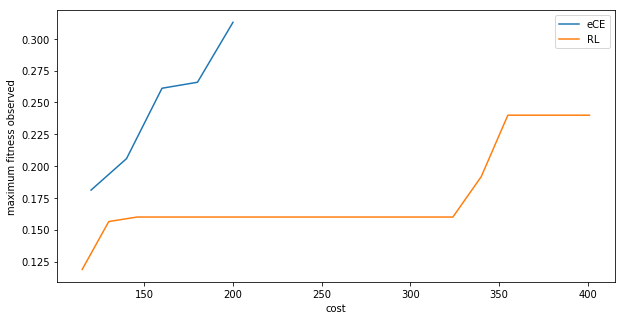

In [0]:
plt.figure(figsize=(10,5))
#plt.xscale("log")
# plt.title(["batch_size",batch_size,"temperature",temperature,"vsp",virtual_per_measure_ratio,"noise",noise_alpha])
plt.xlabel("cost")
plt.ylabel("maximum fitness observed")
plt.plot([s[0] for s in CE_top_seqs], [s[1] for s in CE_top_seqs],label="eCE")
plt.plot([s[0] for s in RL_top_seqs], [s[1] for s in RL_top_seqs],label="RL")

plt.legend()

In [0]:
def compare_diff_parameters(batch_size, generations):
    top_seqs = {}
    top_seqs['CE'] = run_CE(initial_genotypes, batch_size, generations)
    top_seqs['RL_eps'] = run_RL(initial_genotypes, batch_size, generations, "eps")
    top_seqs['RL_thompson'] = run_RL(initial_genotypes, batch_size, generations, "thompson")
    top_seqs['RL_boltzmann'] = run_RL(initial_genotypes, batch_size, generations, "boltzmann")

    plt.figure(figsize=(8,4))
    plt.xlabel("cost")
    plt.ylabel("maximum fitness observed")
    for explorer in ['CE', 'RL_eps', 'RL_thompson', 'RL_boltzmann']:
        plt.plot([s[0] for s in top_seqs[explorer]], [s[1] for s in top_seqs[explorer]],label=explorer)
    plt.legend()
    plt.title("Batch Size={batch_size}, Generations={generations}".format(
        batch_size=batch_size, generations=generations))
    plt.show()
    
    return top_seqs

Batch size: 10, Generations: 20
110 0.1588235294117647
120 0.1964705972110524
130 0.2529411764705882
140 0.278823538387523
150 0.28352941625258504
160 0.30470587786506204
170 0.3070588280172909
180 0.3352941176470588
190 0.34588234845329735
200 0.34588234845329735
103 0.11882353389964384 0.009076349646784365
111 0.11882353389964384 0.002599473512964323
115 0.13882353165570427 0.0008134539792081341
120 0.13882353165570427 0.0005740903565310873
128 0.13882353165570427 0.000490453717065975
130 0.13882353165570427 0.000414972918224521
136 0.13882353165570427 0.00042559468565741556
145 0.16000000448787913 0.0003701461188029498
147 0.16235294342041015 0.0003384532843483612
154 0.16235294342041015 0.0003841103025479242
162 0.16235294342041015 0.0004263398994226009
166 0.16823529636158663 0.00042415239731781186
172 0.16823529636158663 0.00038145798171171916
177 0.1752941131591797 0.0003985968171036802
181 0.20470587786506203 0.0003746829301235266
189 0.21764705882352942 0.00042307188268750904


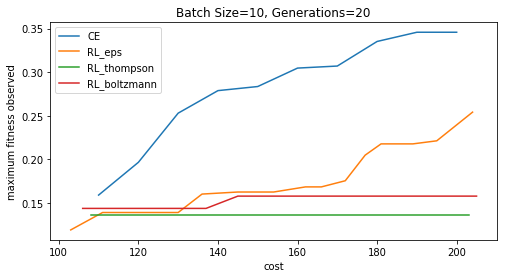

Batch size: 10, Generations: 50
110 0.1894117691937615
120 0.21176470588235294
130 0.2341176425709444
140 0.2341176425709444
150 0.25764705433565027
160 0.27647058823529413
170 0.2988235249238856
180 0.3176470588235294
190 0.32235293668859144
200 0.32823528962976795
210 0.35294117647058826
220 0.36352940727682675
230 0.3682352851418888
240 0.3682352851418888
250 0.378823538387523
260 0.378823538387523
270 0.378823538387523
280 0.378823538387523
290 0.378823538387523
300 0.38235294117647056
310 0.38235294117647056
320 0.3870588414809283
330 0.3964705972110524
340 0.40117645263671875
350 0.40941175573012406
360 0.40941175573012406
370 0.40941175573012406
380 0.40941175573012406
390 0.4117647058823529
400 0.4117647058823529
410 0.41529410867130057
420 0.41529410867130057
430 0.41529410867130057
440 0.41529410867130057
450 0.4317647148581112
460 0.43647057028377756
470 0.4388235204360064
480 0.4388235204360064
490 0.4388235204360064
500 0.44000001795151655
105 0.11882353389964384 0.0061228

381 0.24235294566434973 0.000350335639086552
390 0.24235294566434973 0.00030304162501124663
398 0.24235294566434973 0.00039812169707147403
406 0.24235294566434973 0.00034798438573488963
415 0.24235294566434973 0.0003440516404225491
422 0.24235294566434973 0.000321555943810381
428 0.24235294566434973 0.0003478427490335889
435 0.24235294566434973 0.00031828313949517907
443 0.24235294566434973 0.0003423887974349782
452 0.24235294566434973 0.0003026533842785284
459 0.24235294566434973 0.00029217266128398476
468 0.24235294566434973 0.0003147031122352928
476 0.24235294566434973 0.00028975784516660497
484 0.24235294566434973 0.0003022025251993909
493 0.24235294566434973 0.0002895838362746872
502 0.24235294566434973 0.00030558370926883074


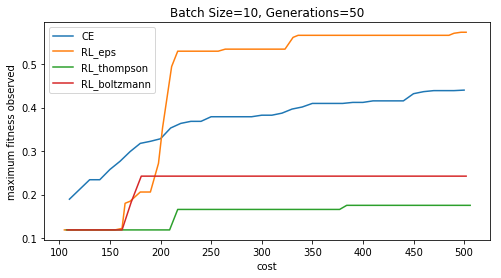

Batch size: 10, Generations: 100
110 0.1588235294117647
120 0.20823530309340532
130 0.26000000448787913
140 0.26000000448787913
150 0.28705881904153263
160 0.2964705972110524
170 0.3317647148581112
180 0.3317647148581112
190 0.33999999551212085
200 0.34705882352941175
210 0.34705882352941175
220 0.35647057925953585
230 0.36705883250517
240 0.36705883250517
250 0.3858823439654182
260 0.3858823439654182
270 0.3858823439654182
280 0.38823529411764707
290 0.38823529411764707
300 0.38823529411764707
310 0.3894117467543658
320 0.3894117467543658
330 0.3964705972110524
340 0.3964705972110524
350 0.3964705972110524
360 0.3964705972110524
370 0.3964705972110524
380 0.39764704984777116
390 0.40470590030445774
400 0.40470590030445774
410 0.40470590030445774
420 0.40470590030445774
430 0.4294117647058823
440 0.4294117647058823
450 0.4294117647058823
460 0.4294117647058823
470 0.4294117647058823
480 0.4470588235294118
490 0.4470588235294118
500 0.4470588235294118
510 0.4470588235294118
520 0.447058

115 0.11882353389964384 0.0022433849226217717
123 0.11882353389964384 0.0007834210002329201
131 0.1305882397819968 0.0004911944794002921
141 0.1305882397819968 0.0004914624849334359
150 0.1305882397819968 0.00048539860872551797
157 0.16941176021800322 0.000408249392057769
166 0.16941176021800322 0.0003886059406795539
172 0.16941176021800322 0.0003310411819256842
178 0.16941176021800322 0.00028946337988600135
184 0.16941176021800322 0.00032025756081566215
190 0.16941176021800322 0.0002784256816084962
196 0.16941176021800322 0.00025626384958741253
206 0.16941176021800322 0.00027451445057522503
214 0.16941176021800322 0.000272955577383982
223 0.16941176021800322 0.00027056110557168724
232 0.16941176021800322 0.00023609541894984432
240 0.16941176021800322 0.0002255765844893176
247 0.16941176021800322 0.00023961867846082895
253 0.16941176021800322 0.0002351080358494073
262 0.16941176021800322 0.00022481696942122653
271 0.16941176021800322 0.00022997755659162066
276 0.16941176021800322 0.000

798 0.2105882308062385 0.00023003167807473802
804 0.2105882308062385 0.0002176228110329248
811 0.2105882308062385 0.00022595740592805668
820 0.2105882308062385 0.00021628085742122493
827 0.2105882308062385 0.00022330380816129036
835 0.2105882308062385 0.00022629496452282184
844 0.2105882308062385 0.00022317697439575568
853 0.2105882308062385 0.00020777029130840673
861 0.2105882308062385 0.00022377349523594603
871 0.2105882308062385 0.00022087070319685154
876 0.2105882308062385 0.00021590836258837952
884 0.2105882308062385 0.0002219097725173924
891 0.2105882308062385 0.0002166324899008032
899 0.2105882308062385 0.00021144868223927916
905 0.2105882308062385 0.0002146767350495793
911 0.2105882308062385 0.00020022075696033426
920 0.2105882308062385 0.0002214765547250863
928 0.2105882308062385 0.00021274681712384335
936 0.2105882308062385 0.00020113645659876057
941 0.2105882308062385 0.00021136103678145445
947 0.2105882308062385 0.00020018101422465407
956 0.2105882308062385 0.00019629946618

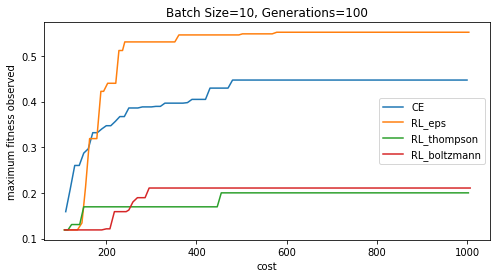

Batch size: 100, Generations: 20
200 0.1741176493027631
300 0.2529411764705882
400 0.27058823529411763
500 0.28470589132869945
600 0.31529410867130053
700 0.34352942074046416
800 0.34588234845329735
900 0.3494117736816406
1000 0.35647057925953585
1100 0.3682352851418888
1200 0.37764704087201284
1300 0.3929411944221048
1400 0.3964705972110524
1500 0.42235295912798715
1600 0.42235295912798715
1700 0.42235295912798715
1800 0.4470588235294118
1900 0.4470588235294118
2000 0.44941177368164065
176 0.11882353389964384 0.007791115087457001
245 0.14352940952076632 0.0021942594030406326
307 0.14352940952076632 0.0009016590600367635
373 0.14352940952076632 0.0005995917017571628
428 0.14352940952076632 0.0005503526263055392
490 0.16235294342041015 0.000574396867887117
553 0.20117647507611444 0.0006148769418359735
603 0.20117647507611444 0.0006218285518116318
641 0.25882352941176473 0.0007693062114412896
688 0.36117647956399357 0.0006479752308223396
733 0.36117647956399357 0.0007301572157302871
777 

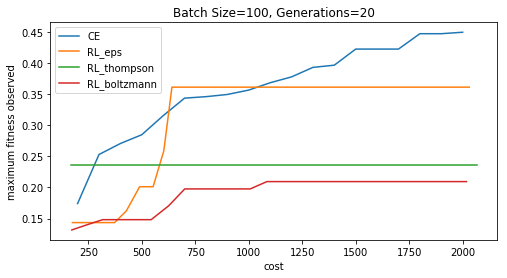

Batch size: 100, Generations: 50
200 0.19176469690659467
300 0.21882353389964385
400 0.26823528514188877
500 0.2811764661003562
600 0.3105882308062385
700 0.3247058868408203
800 0.3447058733771829
900 0.36117647956399357
1000 0.37176471037023207
1100 0.4388235204360064
1200 0.4388235204360064
1300 0.45294117647058824
1400 0.46705883250517005
1500 0.46705883250517005
1600 0.46705883250517005
1700 0.4729411854463465
1800 0.47529413559857536
1900 0.47999999102424173
2000 0.5011764526367187
2100 0.5011764526367187
2200 0.5047059003044577
2300 0.5152941086713005
2400 0.5152941086713005
2500 0.5164706061868106
2600 0.53294116749483
2700 0.53294116749483
2800 0.5411764705882353
2900 0.5411764705882353
3000 0.5411764705882353
3100 0.5411764705882353
3200 0.545882370892693
3300 0.5529411764705883
3400 0.5529411764705883
3500 0.5529411764705883
3600 0.5529411764705883
3700 0.5564705792595358
3800 0.5670588325051701
3900 0.5670588325051701
4000 0.5717646879308363
4100 0.5717646879308363
4200 0.57

3279 0.24470587337718291 0.00035770243557635694
3355 0.24470587337718291 0.0003633028507465497
3426 0.24470587337718291 0.00033746815170161427
3501 0.24470587337718291 0.00032235350663540886
3569 0.24470587337718291 0.0003474196244496852
3644 0.24470587337718291 0.0003299260904896073
3721 0.24470587337718291 0.0003110677731456235
3801 0.24470587337718291 0.000306718991487287
3875 0.24470587337718291 0.00029142095881979914
3951 0.24470587337718291 0.00033713306620484216
4021 0.24470587337718291 0.00031308013130910696
4100 0.24470587337718291 0.0003277351672295481
4175 0.24470587337718291 0.0003167037430102937
4258 0.24470587337718291 0.00033200679608853535
4330 0.24470587337718291 0.0003251785892643966
4412 0.24470587337718291 0.0003253777525969781
4485 0.24470587337718291 0.00030218783940654247
4561 0.24470587337718291 0.00030132172105368227
4635 0.24470587337718291 0.00029161466518417
4705 0.24470587337718291 0.00032722654432291163
4775 0.24470587337718291 0.0003156592298182659
4847 0

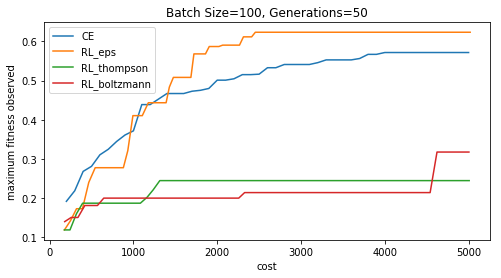

Batch size: 100, Generations: 100
200 0.15764705433565027
300 0.20117647507611444
400 0.2541176515467027
500 0.2694117602180032
600 0.2929411719827091
700 0.3482352986055262
800 0.40941175573012406
900 0.4141176560345818
1000 0.46235293220071233
1100 0.46235293220071233
1200 0.47999999102424173
1300 0.47999999102424173
1400 0.48823529411764705
1500 0.4964705972110524
1600 0.5
1700 0.5282353120691636
1800 0.5282353120691636
1900 0.5282353120691636
2000 0.5282353120691636
2100 0.5282353120691636
2200 0.5400000179515165
2300 0.5400000179515165
2400 0.5400000179515165
2500 0.5411764705882353
2600 0.5411764705882353
2700 0.5588235294117647
2800 0.5588235294117647
2900 0.5635294297162224
3000 0.5635294297162224
3100 0.5635294297162224
3200 0.5647058823529412
3300 0.5776470408720129
3400 0.578823538387523
3500 0.578823538387523
3600 0.578823538387523
3700 0.5823529411764706
3800 0.5823529411764706
3900 0.5823529411764706
4000 0.5823529411764706
4100 0.5823529411764706
4200 0.5823529411764706


6642 0.6235294117647059 0.0006440577562898397
6714 0.6235294117647059 0.0007591721136122942
6769 0.6235294117647059 0.0006513567044748924
6807 0.6235294117647059 0.0007640132651431486
6852 0.6235294117647059 0.000650671313633211
6909 0.6235294117647059 0.0007550209731562064
6956 0.6235294117647059 0.0006488711587735452
7003 0.6235294117647059 0.00074773303931579
7028 0.6235294117647059 0.0006348892449750565
7076 0.6235294117647059 0.0007538343634223565
7120 0.6235294117647059 0.0006338136416161432
7178 0.6235294117647059 0.0007567866399767808
7214 0.6235294117647059 0.0006455953669501468
7242 0.6235294117647059 0.0007308311644010246
7270 0.6235294117647059 0.0006281475012656301
7310 0.6235294117647059 0.0007272620074218139
7350 0.6235294117647059 0.000620836389134638
7397 0.6235294117647059 0.0006624796355026774
7451 0.6235294117647059 0.000663051517040003
7470 0.6235294117647059 0.0006751537483069114
7507 0.6235294117647059 0.0006169900196255184
7544 0.6235294117647059 0.0007256769778

In [0]:
for batch_size in [10,100]:
    for generations in [20, 50, 100]:
        print("Batch size: {}, Generations: {}".format(batch_size, generations))
        top_seqs = compare_diff_parameters(batch_size, generations)
        np.save('./simulations/CE/batch{batch_size}_generations{generations}'.format(
            batch_size=batch_size, generations=generations), top_seqs['CE'])
        for explorer in ['RL_eps', 'RL_thompson', 'RL_boltzmann']:
            np.save('./simulations/RL/{sampling}_batch{batch_size}_generations{generations}'.format(
            sampling=explorer.split('_')[1],batch_size=batch_size, generations=generations), top_seqs[explorer])

In [0]:
def plot_comparison(batch_size, generations):
    top_seqs = {}
    top_seqs['CE'] = np.load('./simulations/CE/batch{batch_size}_generations{generations}.npy'.format(
        batch_size=batch_size, generations=generations))
    for explorer in ['RL_eps', 'RL_thompson', 'RL_boltzmann']:
        top_seqs[explorer] = np.load('./simulations/RL/{sampling}_batch{batch_size}_generations{generations}.npy'.format(
            sampling=explorer.split('_')[1],batch_size=batch_size, generations=generations))
    
    f = plt.figure(figsize=(6,4))
    plt.xlabel("cost")
    plt.ylabel("maximum fitness observed")
    for explorer in ['CE', 'RL_eps', 'RL_thompson', 'RL_boltzmann']:
        plt.plot([s[0] for s in top_seqs[explorer]], [s[1] for s in top_seqs[explorer]],label=explorer)
    plt.title("Batch Size={batch_size}, Generations={generations}".format(
        batch_size=batch_size, generations=generations))
    plt.legend()
    plt.tight_layout()
    plt.show()
    return f

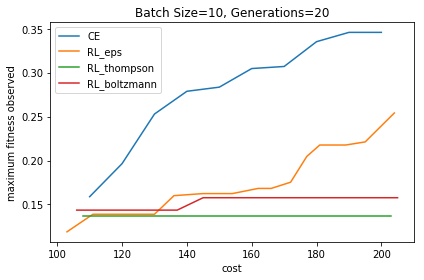

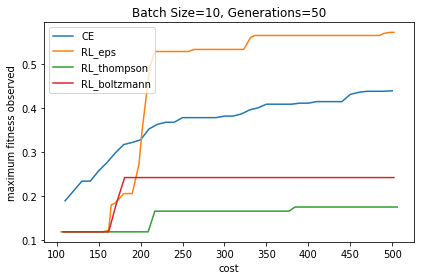

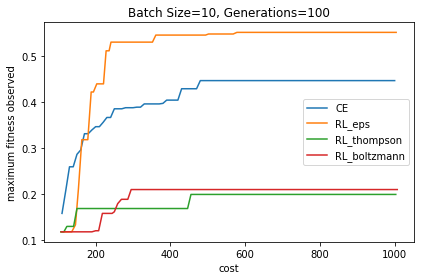

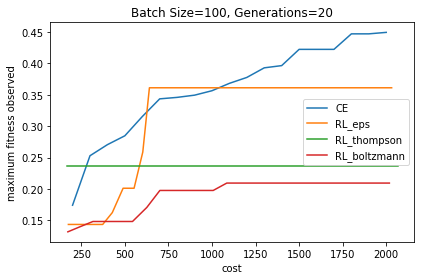

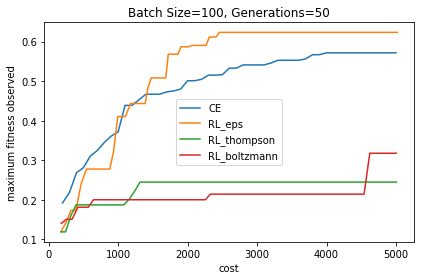

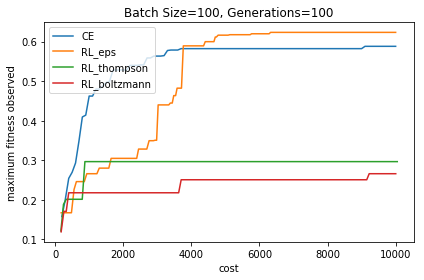

In [0]:
for batch_size in [10,100]:
    for generations in [20,50,100]:
        f = plot_comparison(batch_size, generations)
        f.savefig("./figs/comparison_batch{batch_size}_generations{generations}".format(
            batch_size=batch_size, generations=generations))

# Multiple RL agents

In [0]:
class RL_agent_QN():

    def __init__(self,start_sequence,alphabet,gamma=0.9,memory_size=1000):
        self.alphabet=alphabet
        self.state=translate_string_to_one_hot(start_sequence,self.alphabet)
        self.seq_size=len(start_sequence)
        self.actor=build_model(self.seq_size,len(self.alphabet))
        self.start_sequence=translate_string_to_one_hot(start_sequence,self.alphabet)
        self.gamma=gamma
        self.memory=[]
        self.memory_size=memory_size

    def reset_position(self,sequence):
        self.state=translate_string_to_one_hot(sequence,self.alphabet)

    def get_position(self):
        return translate_one_hot_to_string(self.state,self.alphabet)

    def translate_pwm_to_sequence(self,input_seq_one_hot,output_pwm):
        diff=output_pwm-input_seq_one_hot
        most_likely=np.argmax(diff,axis=0)
        out_seq=""
        for m in most_likely:
            out_seq+=self.alphabet[m]
        return out_seq

    def observe(self,landscape,genotypes,costly=False,num_observations=50,epsilon=0.2,depth=10):
        if genotypes:
            new_sequences=make_one_hot_genotypes(genotypes,self.alphabet)
        elif self.memory:
            new_sequences=make_one_hot_genotypes(self.memory[-num_observations:],self.alphabet)
        else:
            return "Nothing to observe"
        new_moves=[]
        all_moves=[]
        
        #all_fitnesses=[]
        for i in range(depth):
            for genotype in new_sequences:
                if random.random()<epsilon:
                    genotype_tensor = torch.from_numpy(np.expand_dims(genotype,axis=0)).float()
                    prediction = self.actor(genotype_tensor)
                    prediction = prediction.detach().numpy()[0]
                    #moves=walk_away_renormalize_moves(genotype,self.start_sequence,prediction)
                    moves=renormalize_moves(genotype,prediction)

                    sample=sample_random(moves)
                    mutant=construct_mutant_from_sample(sample,genotype)
                    new_moves.append(translate_one_hot_to_string(mutant,self.alphabet))
                else:
                    genotype_tensor = torch.from_numpy(np.expand_dims(genotype,axis=0)).float()
                    prediction = self.actor(genotype_tensor)
                    prediction = prediction.detach().numpy()[0]
                    #moves=walk_away_renormalize_moves(genotype,self.start_sequence,prediction)
                    moves=renormalize_moves(genotype,prediction)
                    
                    sample=sample_boltzman(moves)
                    mutant=construct_mutant_from_sample(sample,genotype)
                    new_moves.append(translate_one_hot_to_string(mutant,self.alphabet))
            if costly:
                landscape.measure_true_landscape(new_moves)
#             else:
#                 landscape.genotype_fitnesses(new_moves)

            new_sequences=np.stack([translate_string_to_one_hot(move,self.alphabet) for move in new_moves])
            all_moves.extend(new_moves)
            #all_fitnesses.append(new_fitnesses)
            new_moves=[]
        self.memory=all_moves[-self.memory_size:] #store at most 1000 memories
        return all_moves

    def train_actor(self, landscape, observations, train_epochs=10):
        loss_fxn = nn.MSELoss()
        optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        total_loss = 0.
        for epoch in range(train_epochs):     
            moves = observations #random.sample(observations, train_size)
            genotypes_one_hot, genotype_fitnesses, t_1, t_2 = make_one_hot_train_test(moves, landscape, self.alphabet)
            optimizer.zero_grad()
            genotypes_one_hot_tensor = torch.from_numpy(genotypes_one_hot).float()
            outputs = self.actor(genotypes_one_hot_tensor)
            genotype_fitnesses = torch.tensor(genotype_fitnesses, requires_grad=True).float()
            loss = loss_fxn(outputs, genotype_fitnesses)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#         print('[%d] Avg loss: %.3f' % (epoch+1, total_loss / (epoch + 1)))
        return (total_loss / (epoch+1))

    def xtrain_actor(self,landscape, observations, train_epochs=10):
        loss_fxn = nn.MSELoss()
        optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        total_loss = 0.0
        for epoch in range(train_epochs):
            moves = observations
            genotypes_one_hot, genotype_fitnesses, t_1, t_2 = make_one_hot_train_test(moves, landscape, self.alphabet)
            optimizer.zero_grad()
            genotypes_one_hot_tensor = torch.from_numpy(genotypes_one_hot).float()
            outputs = self.actor(genotypes_one_hot_tensor)
            genotype_fitnesses = torch.tensor(genotype_fitnesses, requires_grad=True).float()
            loss = loss_fxn(outputs, genotype_fitnesses)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return (total_loss / (epoch+1))

    def pick_action_epsilon_greedy(self,epsilon=0.1):
            state_tensor = torch.from_numpy(np.expand_dims(self.state,axis=0)).float()
            prediction=self.actor(state_tensor)
            prediction = prediction.detach().numpy()[0]
            #moves=walk_away_renormalize_moves(self.state,self.start_sequence,prediction)
            moves=renormalize_moves(self.state,prediction)
#             print(self.state)
#             print(state_tensor)
#             print(prediction)
            if random.random()<epsilon:
                sample=sample_random(moves)
#                 print("eps", sample)
                mutant=construct_mutant_from_sample(sample,self.state)
                mutant_string=translate_one_hot_to_string(mutant,self.alphabet)
            else:
                sample=sample_greedy(moves)
#                 print("greedy", sample)
                mutant=construct_mutant_from_sample(sample,self.state)
                mutant_string=translate_one_hot_to_string(mutant,self.alphabet)

            self.state=mutant
            self.memory.append(mutant_string)

            return mutant_string
        
class RL_multi_agent_QN():
    def __init__(self,agent_type,landscape,wt,alphabet, pop_size,memory_size=1200,best_seq_prop=1):
        self.memory=[]
        self.pop_size=pop_size
        self.alphabet=alphabet
        self.wt=wt
        self.agents=[agent_type(self.wt,self.alphabet) for i in range(self.pop_size)]
        self.memory_size=memory_size
        self.memory=[]
        self.landscape=landscape
        self.best_seqs=[]
        self.best_seqs_len=self.pop_size*best_seq_prop

    def add_to_top_seqs(self,sequence):
        fitness= self.landscape.get_fitness(sequence)
        if len(self.best_seqs)<self.best_seqs_len:
            self.best_seqs.append((fitness,sequence))

        else:
            if fitness > self.best_seqs[0][0] and (fitness,sequence) not in self.best_seqs:
                self.best_seqs.append((fitness,sequence))
                self.best_seqs=sorted(self.best_seqs)
                self.best_seqs=self.best_seqs[1:]


    def reset_position(self,sequence):
        for agent in self.agents:
            agent.reset_position(sequence)

    def observe(self, num_observations=1000, costly=False, depth=10):
        for agent in self.agents:
            observations=agent.observe(self.landscape,[generate_random_mutant(agent.get_position(),0.1,self.alphabet) for i in range(num_observations)],costly=True,depth=depth)
            self.memory.extend(observations)
        if len(self.memory)>self.memory_size:
            self.memory=random.sample(self.memory,self.memory_size)
            
    def force_observations(self, observations):
        num_agents = len(self.agents)
        for agent in self.agents:
            agent.memory.extend(observations)
            if len(agent.memory) > agent.memory_size:
                agent.memory = random.sample(agent.memory, agent.memory_size)

    def train_agents(self, observations):
        total_loss = 0.0
        for agent in self.agents:
            total_loss += agent.train_actor(self.landscape, observations, train_epochs=20)
        return total_loss/len(self.agents)

    def cross_train_agents(self, observations, num_x_obs=1000):
        agents=random.sample(self.agents, num_agents)
        total_loss = 0.0
        for agent in self.agents:
            total_loss += agent.xtrain_actor(self.landscape, random.sample(observations,num_x_obs), train_epochs=20)
        return total_loss/len(self.agents)


    def pick_action(self, epsilon):
        self.sequences=[]
        for agent in self.agents:
            self.sequences.append(agent.pick_action_epsilon_greedy(epsilon=epsilon))
#             self.memory.extend(agent.memory)

#         if len(self.memory)>self.memory_size:
#             self.memory=random.sample(self.memory,self.memory_size)

        for seq in self.sequences:
            self.add_to_top_seqs(seq)

        return self.sequences

In [0]:
noise_alpha=1
batch_size=20
virtual_per_measure_ratio=15
temperature=0.1
generations=20

noisy_landscape_RL_multiple.reset()
noisy_landscape_RL_multiple.measure_true_landscape(initial_genotypes)
noisy_landscape_RL_multiple.natural_mode=False
noisy_landscape_RL_multiple.local_mode=False
noisy_landscape_RL_multiple.cost

num_agents = 10
multi_agents = RL_multi_agent_QN(RL_agent_QN,
                          noisy_landscape_RL_multiple,
                          wt,
                          RAA,
                          num_agents,
                          memory_size=batch_size)

# setting different initial positions for each
for i in range(num_agents):
    multi_agents.agents[i].reset_position(initial_genotypes[i])

observations = [x for x in initial_genotypes]
new_sequences = sorted([(noisy_landscape_RL_multiple.get_fitness(observations[i]),[observations[i]])
                        for i in range(len(observations))])

multi_RL_top_seqs = []
while noisy_landscape_RL_multiple.cost < batch_size * generations:
    eps = max(0.2, (0.5 - noisy_landscape_RL_multiple.cost / (batch_size * generations)))
    b = 0
    new = []
    while (b < batch_size):
        seqs = multi_agents.pick_action(epsilon=eps)
        for s in seqs:
            if not s in noisy_landscape_RL_multiple.measured_sequences.keys():
                new += [s]
                b += 1
    noisy_landscape_RL_multiple.measure_true_landscape(new)
    observations += new
#     multi_agents.force_observations(observations)
    avg_loss = multi_agents.train_agents(observations)
    print(noisy_landscape_RL_multiple.cost, noisy_landscape_RL_multiple.get_fitness(new_sequences[-1][1][0]), avg_loss)
    new_sequences += [(noisy_landscape_RL_multiple.get_fitness(new[i]),[new[i]]) for i in range(len(new))]
    new_sequences = sorted(new_sequences)
    multi_RL_top_seqs += [(noisy_landscape_RL_multiple.cost, new_sequences[-1][0])]

126 0.12470588684082032 0.006890007394831627
146 0.12470588684082032 0.0015382842053077183
175 0.12470588684082032 0.0005607033502019477
195 0.12470588684082032 0.0005126100419147405
215 0.13999999551212086 0.0004502509706071578
238 0.13999999551212086 0.0004053742884570965
261 0.15764705433565027 0.0003647093381732702
287 0.16000000448787913 0.0004030324509949423
312 0.1964705972110524 0.0004038950226095039
339 0.1964705972110524 0.0004627102144877427
360 0.23999999551212087 0.0005041886515391525
380 0.3 0.0005245681472297292
403 0.3058823529411765 0.0004860679774719755


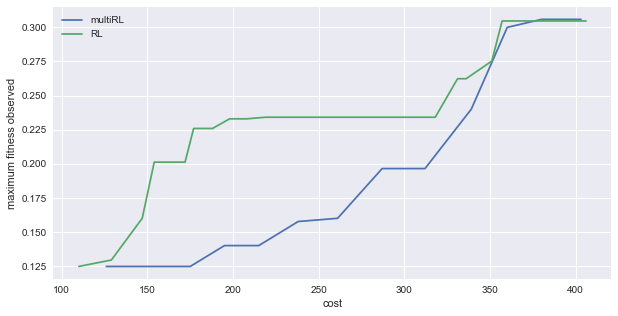

In [0]:
plt.figure(figsize=(10,5))
plt.xlabel("cost")
plt.ylabel("maximum fitness observed")
plt.plot([s[0] for s in multi_RL_top_seqs], [s[1] for s in multi_RL_top_seqs],label="multiRL")
plt.plot([s[0] for s in RL_top_seqs], [s[1] for s in RL_top_seqs],label="RL")
plt.legend()
plt.show()

In [0]:
multi_agents.best_seqs

[(0.4682352851418888, 'CGCGGCCUCCCCUGGGGUACCCCCAGGGGGGGCCGUGGGA'),
 (0.4682352851418888, 'UAUGUGGCCCCGGGGGCCAUUGGGCCCCCGGGGCCACCAG'),
 (0.4776470408720129, 'CAGGUGGCCCCGGGGGCCAGUGGGCCCCCGGGGCCACGUU'),
 (0.4776470408720129, 'CAGGUGGCCCCGGGGGCCAUUGGGCCCCCGGGGCCACGAU'),
 (0.49294119442210477, 'CGCGGCCCCCCCUGGGGUACCCCCAGGGGGGGCCGUGCGC'),
 (0.49882354736328127, 'CAGGUGGCCCCGGGGGCGAUGGGGCCCCCGGGGCCACCUU'),
 (0.49882354736328127, 'CAGGUGGCCCCGGGGGCGCUGGGGCCCCCGGGGCCACCUU'),
 (0.5035294027889476, 'CGCGGCCCCCCCUGGGGUACCCCCAGGGGGGGCCGUGGCA'),
 (0.5035294027889476, 'CGCGGCCCCCCCUGGGGUACCCCCAGGGGGGGCCGUGGGA'),
 (0.5152941086713005, 'UAGGUGGCCCCGGGGGCCAUUGGGCCCCCGGGGCCACCAG')]

AttributeError: 'Agent_pop' object has no attribute 'top_sequence'

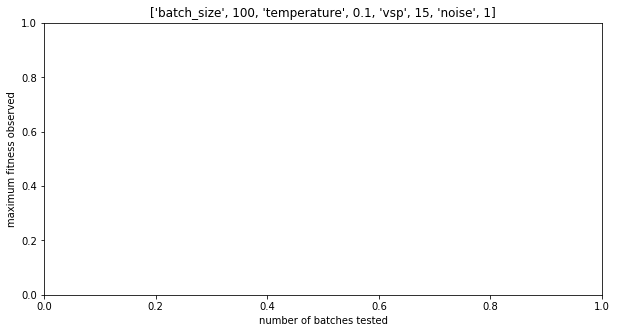

In [0]:
plt.figure(figsize=(10,5))
#plt.xscale("log")
# plt.title(["batch_size",batch_size,"temperature",temperature,"vsp",virtual_per_measure_ratio,"noise",noise_alpha])
plt.xlabel("number of batches tested")
plt.ylabel("maximum fitness observed")
plt.plot([t[2]/batch_size for t in popAg.best_seqs[1:]],[t[0] for t in popAg.best_seqs[1:]],label="popAg")

plt.legend()
plt.xticks(range(generations));